**По датасетам**

Нашел, какими датасетами можно воспользоваться: вначале расскажу, как у нас набираются ханипоты (контрольные задания для проверки качества разметки толокерами)
* Толокерам даются боевые задания, которые они размечают (обычная разметка, за которую мы им платим)
* Из того, что разметили толокеры, с определенной периодичностью(неделя или месяц) берется семпл заданий(например, 500 заданий) и они размечаются ассесорами(наши доверенные разметчики, которые у нас работают в штате и мы считаем, что их качество можно считать ground truth)
* Далее размеченные задания добавляются в общий пул ханипотов и в дальнейших пулах на этих ханипотах уже оценивает качество разметки толокеров
Я нашел два проекта(разметки), которые нам могут подходить в качестве датасетов:
1. **Разметка картинок на визуальное качество(для картинок)**
* Разметка предполагает, что толокеру дается картинка и его задача сказать, какого она качества (хорошего, среднего или плохого). Выглядит это так:
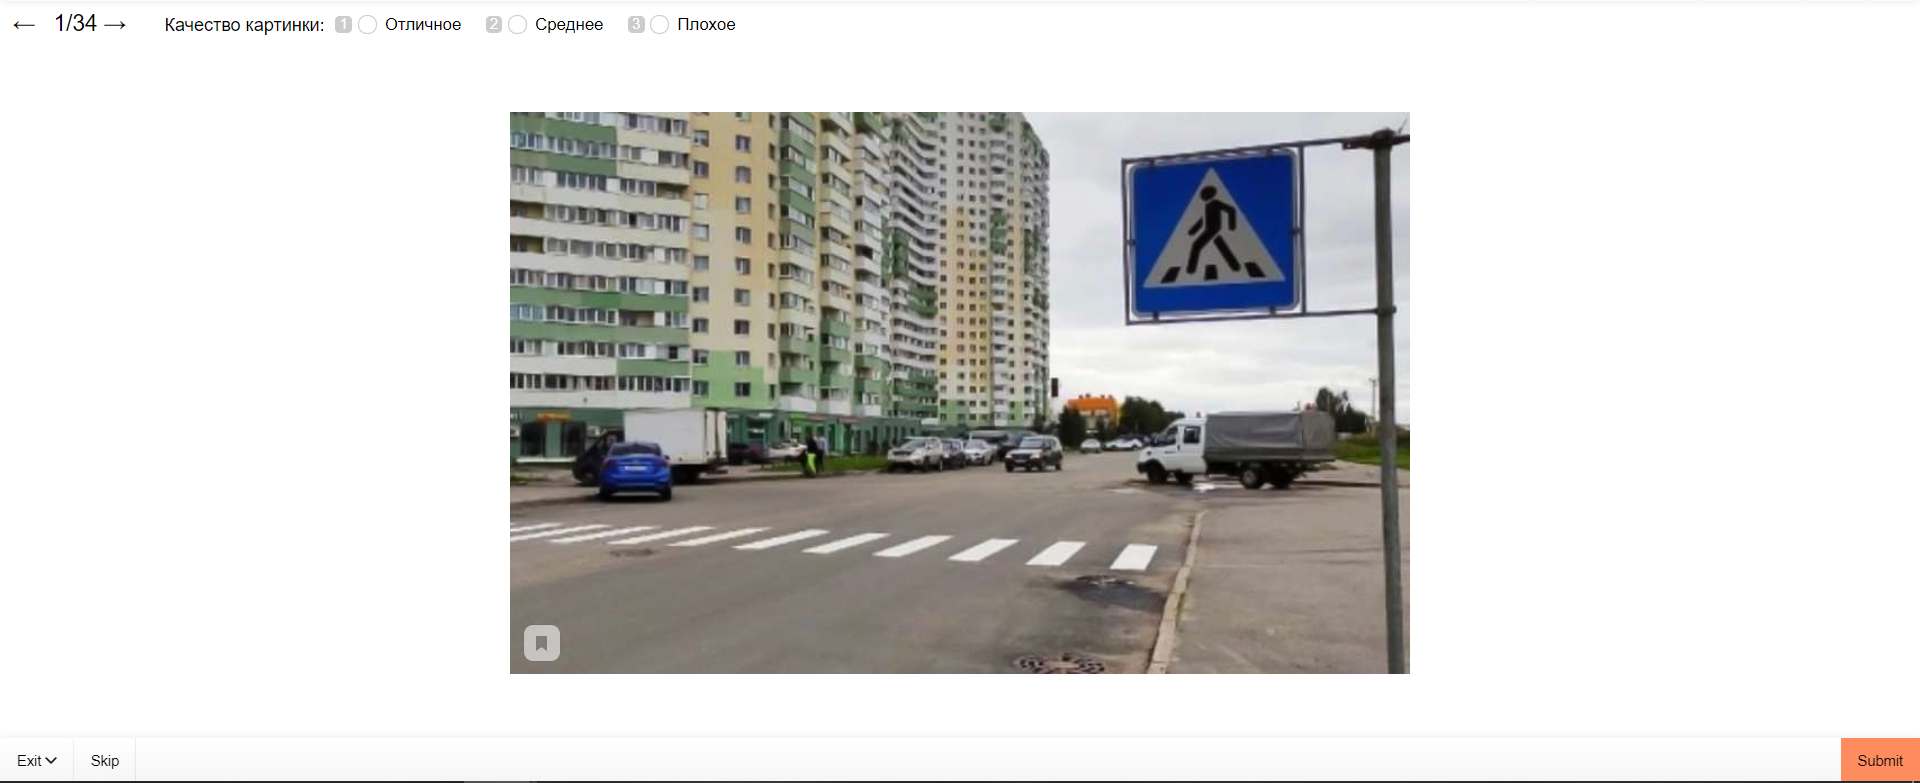
* В хранилище находится около **64 160** ханипотов. Их распределение **(GOOD-OK-BAD: 37%-31%-32%)**, немного смещенное.
* Но не по всем ханипотам подтянулась история в лице толокерских ответов: она есть только у **28 954** ханипотов. По ним идеальное распределение **(GOOD-OK-BAD: 34%-32%-33%)**. То, что не подтянулись ответы толокеров довольно странно, я это спрашивать буду в понедельник, возможно раньше был какой то другой процесс сбора ханипотов, но даже так, мы можем использовать ханипоты по которым не подтянулась история, например как в статье или random_flip. Неподтянушвихся ханипотов **35 206**. По не подтянувшимся ханипотам следующее распределение: **(GOOD-OK-BAD: 39%-30%-31%)**
* Возможно нужно будет срезать из ханипотов, к которым подтянулась история около 3к строк, у них почему то только один ответ толокера подтянулся, что странно
* я оценил "шумность" датасета двумя способами:
  * сравнил ответ ассесора(ground_truth) и случайный ответ толокера из истории: получилась **77.6% совпадений**
  * сравнил ответ ассесора(ground_truth) и агрегированный ответ толокера(из истории выбрал самый частый): получилась **85.4% совпадений**
* впринципе я доволен такими результатами, это нижняя и верхняя оценка шумности датасета, дальше мы можем пробовать другие способы агрегации истории толокеров, если захотим выше или ниже уровень шумности датасета
* **суммируя вышенаписанное, мне нравится этот датасет и я бы хотел его использовать: задача простая, датасет большой + недавно к нам приходила смежная группа, они рассказывали, что они экспериментировали с этим проектом, используя резнет, чтобы увеличить точность ответов толокеров, возможно я смогу переиспользовать их наработки.**

2. **Разметка Связаны ли запросы или нет(для текста)**
* Разметка предполагает, что толокеру дается два запроса и его задача, чтобы он сказал, как эти два запроса соотносятся. Выглядит это так:
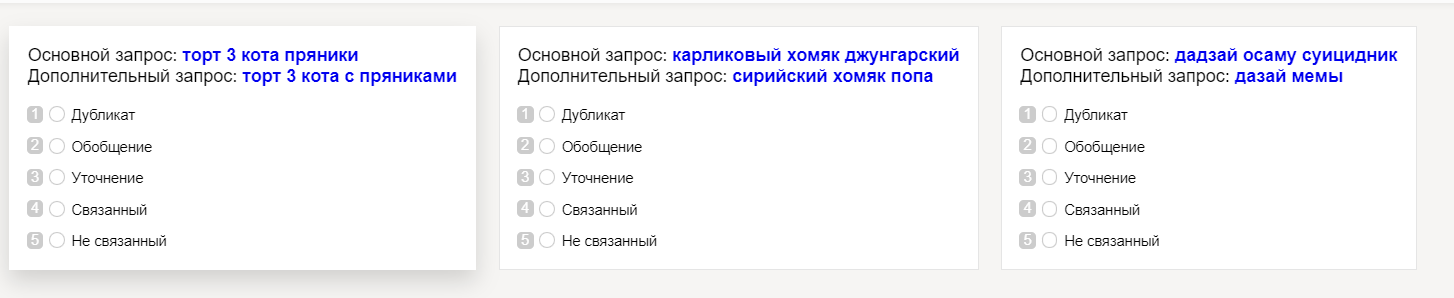
* В хранилище находится около **3 363** ханипотов. Их распределение **(уточнение-связанные-обобщение-дубли-несвязанные запросы: 53%-5%-5%-23%-4%)**, какое то ужасное распределение но возможно мы это можем использовать как пример несбалансированного датасета + я думал может стоит смерджить какие то классы, например (обобщение, уточнение и связанные) в один класс, в таком случае будет три класса.
* я оценил "шумность" датасета двумя способами:
  * сравнил ответ ассесора(ground_truth) и случайный ответ толокера из истории: получилась **77.1% совпадений**
  * сравнил ответ ассесора(ground_truth) и агрегированный ответ толокера(из истории выбрал самый частый): получилась **90.4% совпадений**
* точность даже выше чем у картиночной разметки, что очень странно, может где то ошибся.
* **по этой разметке у меня сомнения, она небольшая, всего 3к запросов, плюс перекос классов, но проблема в том, что я у нас не нашел какую-либо другую текстовую разметку, мы обычно не размечаем чисто текстовые задачи, обычно это связка картинка + запрос, поэтому здесь я 70% за использование этого датасета, 30% против.**

In [2]:
from nile.api.v1 import (
    clusters,
    aggregators as na
)

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sns.set()
pd.set_option('display.min_rows', 50)
cluster = clusters.Hahn()

In [3]:
def add_annotations(title, xlabel, ylabel, legend=True):
    if legend:
        plt.legend()
    plt.xlabel(title)
    plt.ylabel(xlabel)
    plt.title(ylabel)

# 0. Загрузка таблиц

In [4]:
path = '//home/images/dev/spochukaev/hse_diploma/image_classification_with_answers'
image_class = cluster.read(path).as_dataframe()

path = '//home/images/dev/spochukaev/hse_diploma/image_classification_all_honeypots'
image_all = cluster.read(path).as_dataframe()

path = '//home/images/dev/spochukaev/hse_diploma/text_classification'
text_class = cluster.read(path).as_dataframe()

path = '//home/images/dev/spochukaev/hse_diploma/text_classification_all_honeypots'
text_all = cluster.read(path).as_dataframe()

In [5]:
# при выгрузке колонки с текстом выгружаются в binary формате
image_class['aggr_answer'] = image_class['aggr_answer'].str.decode('utf8')
image_class['assessors_answer'] = image_class['assessors_answer'].str.decode('utf8')
image_class['some_answer'] = image_class['some_answer'].str.decode('utf8')
image_class['query'] = image_class['query'].str.decode('utf8')
image_class['least_common'] = image_class['least_common'].str.decode('utf8')
image_class['list_answers'] = image_class['list_answers'].str.decode('utf8')


text_class['aggr_answer'] = text_class['aggr_answer'].str.decode('utf8')
text_class['assessors_answer'] = text_class['assessors_answer'].str.decode('utf8')
text_class['some_answer'] = text_class['some_answer'].str.decode('utf8')
text_class['query'] = text_class['query'].str.decode('utf8')
text_class['related_query'] = text_class['related_query'].str.decode('utf8')
text_class['least_common'] = text_class['least_common'].str.decode('utf8')

image_all['assessors_answer'] = image_all['assessors_answer'].str.decode('utf8')
image_all['query'] = image_all['query'].str.decode('utf8')

text_all['assessors_answer'] = text_all['assessors_answer'].str.decode('utf8')
text_all['query'] = text_all['query'].str.decode('utf8')
text_all['related_query'] = text_all['related_query'].str.decode('utf8')

In [88]:
# первые 5 строк каждой таблицы
# query - урл страницы где хранится картинка
# assesors_answer - ответ, который дал ассесор
image_all.head(5)

assessors_answer                                              query
0              BAD  http://storage.mds.yandex.net:80/get-mimcache/...
1             GOOD  http://storage.mds.yandex.net:80/get-mimcache/...
2               OK  http://storage.mds.yandex.net:80/get-mimcache/...
3               OK  http://storage.mds.yandex.net:80/get-mimcache/...
4             GOOD  http://storage.mds.yandex.net:80/get-mimcache/...

In [89]:
# первые 5 строк каждой таблицы
# query - запрос пользователя
# related_query - связанный запрос пользователя
# assesors_answer - ответ, который дал ассесор
text_all.head(5)

assessors_answer                               query  \
0             DUPS     этот неловкий момент фильм 2015   
1              REF         константин васильев картины   
2             DUPS                    huawwei p20 lite   
3              REF                         надпись юля   
4              REL  люди икс: тёмный феникс фильм 2019   

                         related_query  
0            Этот неловкий момент 2015  
1  Картина Васильева человек с филином  
2                      Хуавей р20 Лайт  
3       Надпись Юля на прозрачном фоне  
4                Джин грей Софи Тернер

In [90]:
# первые 5 строк каждой таблицы
# query - урл страницы где хранится картинка
# assesors_answer - ответ, который дал ассесор
# cnt - количество оценок толокеров(это своего рода размер истории ответов толокеров на этот ханипот, то есть сколько у меня есть ответов толокеров на этот ханипот)
# some_answer - случайная оценка толокера из истории ханипота
# aggr_answer - агрегированная оценка ханипота(самая частая оценка в истории)
image_class.head(5)

aggr_answer assessors_answer  cnt least_common  \
0         BAD              BAD   15           OK   
1         BAD              BAD    2          BAD   
2         BAD              BAD    6          BAD   
3         BAD              BAD   11          BAD   
4         BAD              BAD   10           OK   

                                               query some_answer  
0  http://storage.mds.yandex.net:80/get-mimcache/...         BAD  
1  http://storage.mds.yandex.net:80/get-mimcache/...         BAD  
2  http://storage.mds.yandex.net:80/get-mimcache/...         BAD  
3  http://storage.mds.yandex.net:80/get-mimcache/...         BAD  
4  http://storage.mds.yandex.net:80/get-mimcache/...          OK

In [91]:
# первые 5 строк каждой таблицы
# query - запрос пользователя
# related_query - связанный запрос пользователя
# assesors_answer - ответ, который дал ассесор
# cnt - количество оценок толокеров(это своего рода размер истории ответов толокеров на этот ханипот, то есть сколько у меня есть ответов толокеров на этот ханипот)
# some_answer - случайная оценка толокера из истории ханипота
# aggr_answer - агрегированная оценка ханипота(самая частая оценка в истории)
text_class.head(5)

aggr_answer assessors_answer  cnt least_common                 query  \
0        DUPS             DUPS   30          REL        "девять ярдов"   
1        DUPS             DUPS   30          REF          100 долларов   
2        DUPS             DUPS   30          REF    2 3 4 player games   
3        DUPS             DUPS   25         DUPS              200 рубл   
4        DUPS             DUPS   30          REL  2019-yili nomlanishi   

                              related_query some_answer  
0  Девять ярдов the whole Nine Yards (2000)        DUPS  
1                     100 Долларовая купюра        DUPS  
2        Игра на двоих на троих на четверых        DUPS  
3                                200 Рублей        DUPS  
4                        2019 Йил номланиши        DUPS

### 2 текстовая разметка

In [11]:
path = '//home/images/dev/spochukaev/hse_diploma/text_classification_with_answers_2'
text_class_2 = cluster.read(path).as_dataframe()

path = '//home/images/dev/spochukaev/hse_diploma/text_classification_all_honeypots_3'
text_all_2 = cluster.read(path).as_dataframe()

In [12]:
text_class_2['aggr_answer'] = text_class_2['aggr_answer'].str.decode('utf8')
text_class_2['assessors_answer'] = text_class_2['assessors_answer'].str.decode('utf8')
text_class_2['some_answer'] = text_class_2['some_answer'].str.decode('utf8')
text_class_2['query'] = text_class_2['query'].str.decode('utf8')
text_class_2['least_common'] = text_class_2['least_common'].str.decode('utf8')

text_all_2['assessors_answer'] = text_all_2['assessors_answer'].str.decode('utf8')
text_all_2['query'] = text_all_2['query'].str.decode('utf8')

In [186]:
text_class_2.head()

aggr_answer assessors_answer  cnt    least_common  \
0      COMMERCIAL       COMMERCIAL  151  NOT_COMMERCIAL   
1      COMMERCIAL       COMMERCIAL   45  NOT_COMMERCIAL   
2  NOT_COMMERCIAL       COMMERCIAL   15      COMMERCIAL   
3      COMMERCIAL       COMMERCIAL   45  NOT_COMMERCIAL   
4      COMMERCIAL       COMMERCIAL   10  NOT_COMMERCIAL   

                                        list_answers  \
0  b'COMMERCIAL, NOT_COMMERCIAL, COMMERCIAL, COMM...   
1  b'COMMERCIAL, COMMERCIAL, COMMERCIAL, COMMERCI...   
2  b'COMMERCIAL, NOT_COMMERCIAL, COMMERCIAL, NOT_...   
3  b'COMMERCIAL, NOT_COMMERCIAL, COMMERCIAL, NOT_...   
4  b'COMMERCIAL, COMMERCIAL, COMMERCIAL, COMMERCI...   

                       query some_answer  
0            "Штиль sr1103l"  COMMERCIAL  
1                  0585485sx  COMMERCIAL  
2  10р города воинской славы  COMMERCIAL  
3                 135930-m/t  COMMERCIAL  
4          14813 Паола Рейна  COMMERCIAL

In [187]:
text_all_2.head()

assessors_answer              query
0   NOT_COMMERCIAL  академия вампиров
1   NOT_COMMERCIAL   ффото/zoe_parker
2   NOT_COMMERCIAL   хайтек тирасполь
3       COMMERCIAL  хлорофитум горшок
4   NOT_COMMERCIAL             радмир

In [29]:
text_class_2.shape

(21402, 10)

In [32]:
text_class_2[(~text_class_2['english']) & (text_class_2['russian']) & (~text_class_2['ukrain'])]

aggr_answer assessors_answer  cnt    least_common  \
2      NOT_COMMERCIAL       COMMERCIAL   15      COMMERCIAL   
4          COMMERCIAL       COMMERCIAL   10  NOT_COMMERCIAL   
10     NOT_COMMERCIAL       COMMERCIAL   55      COMMERCIAL   
11     NOT_COMMERCIAL       COMMERCIAL   20      COMMERCIAL   
13         COMMERCIAL       COMMERCIAL  670  NOT_COMMERCIAL   
24     NOT_COMMERCIAL       COMMERCIAL   60      COMMERCIAL   
25         COMMERCIAL       COMMERCIAL   15  NOT_COMMERCIAL   
27         COMMERCIAL       COMMERCIAL   10  NOT_COMMERCIAL   
33         COMMERCIAL       COMMERCIAL   50  NOT_COMMERCIAL   
34         COMMERCIAL       COMMERCIAL   15  NOT_COMMERCIAL   
291    NOT_COMMERCIAL       COMMERCIAL   35      COMMERCIAL   
976    NOT_COMMERCIAL       COMMERCIAL  165      COMMERCIAL   
978        COMMERCIAL       COMMERCIAL   20  NOT_COMMERCIAL   
979        COMMERCIAL       COMMERCIAL   15  NOT_COMMERCIAL   
980    NOT_COMMERCIAL       COMMERCIAL  170      COMMERCIAL   
981        COMMERCIAL       COMMERCIAL   15  NOT_COMMERCIAL   
982        COMMERCIAL       COMMERCIAL   10  NOT_COMMERCIAL   
983        COMMERCIAL       COMMERCIAL  318  NOT_COMMERCIAL   
984    NOT_COMMERCIAL       COMMERCIAL    5      COMMERCIAL   
985        COMMERCIAL       COMMERCIAL  751  NOT_COMMERCIAL   
987        COMMERCIAL       COMMERCIAL   11      COMMERCIAL   
989        COMMERCIAL       COMMERCIAL  155  NOT_COMMERCIAL   
990        COMMERCIAL       COMMERCIAL   15      COMMERCIAL   
992        COMMERCIAL       COMMERCIAL   20      COMMERCIAL   
993        COMMERCIAL       COMMERCIAL   10      COMMERCIAL   
...               ...              ...  ...             ...   
21368  NOT_COMMERCIAL   NOT_COMMERCIAL    5  NOT_COMMERCIAL   
21369  NOT_COMMERCIAL   NOT_COMMERCIAL   10      COMMERCIAL   
21370  NOT_COMMERCIAL   NOT_COMMERCIAL  157      COMMERCIAL   
21371  NOT_COMMERCIAL   NOT_COMMERCIAL   10  NOT_COMMERCIAL   
21372      COMMERCIAL   NOT_COMMERCIAL   20  NOT_COMMERCIAL   
21373  NOT_COMMERCIAL   NOT_COMMERCIAL   10  NOT_COMMERCIAL   
21374  NOT_COMMERCIAL   NOT_COMMERCIAL   10  NOT_COMMERCIAL   
21375  NOT_COMMERCIAL   NOT_COMMERCIAL   10      COMMERCIAL   
21376  NOT_COMMERCIAL   NOT_COMMERCIAL   10  NOT_COMMERCIAL   
21377  NOT_COMMERCIAL   NOT_COMMERCIAL   10      COMMERCIAL   
21378  NOT_COMMERCIAL   NOT_COMMERCIAL   15  NOT_COMMERCIAL   
21379  NOT_COMMERCIAL   NOT_COMMERCIAL   30      COMMERCIAL   
21380  NOT_COMMERCIAL   NOT_COMMERCIAL   20      COMMERCIAL   
21381  NOT_COMMERCIAL   NOT_COMMERCIAL   10  NOT_COMMERCIAL   
21382  NOT_COMMERCIAL   NOT_COMMERCIAL    5  NOT_COMMERCIAL   
21383  NOT_COMMERCIAL   NOT_COMMERCIAL   10  NOT_COMMERCIAL   
21384  NOT_COMMERCIAL   NOT_COMMERCIAL   10  NOT_COMMERCIAL   
21385  NOT_COMMERCIAL   NOT_COMMERCIAL   10  NOT_COMMERCIAL   
21386      COMMERCIAL   NOT_COMMERCIAL   15  NOT_COMMERCIAL   
21387  NOT_COMMERCIAL   NOT_COMMERCIAL   20      COMMERCIAL   
21388  NOT_COMMERCIAL   NOT_COMMERCIAL   25  NOT_COMMERCIAL   
21389      COMMERCIAL   NOT_COMMERCIAL   20  NOT_COMMERCIAL   
21390  NOT_COMMERCIAL   NOT_COMMERCIAL   15  NOT_COMMERCIAL   
21391      COMMERCIAL   NOT_COMMERCIAL   25  NOT_COMMERCIAL   
21392  NOT_COMMERCIAL   NOT_COMMERCIAL   10  NOT_COMMERCIAL   

                                            list_answers  \
2      b'COMMERCIAL, NOT_COMMERCIAL, COMMERCIAL, NOT_...   
4      b'COMMERCIAL, COMMERCIAL, COMMERCIAL, COMMERCI...   
10     b'NOT_COMMERCIAL, NOT_COMMERCIAL, NOT_COMMERCI...   
11     b'NOT_COMMERCIAL, NOT_COMMERCIAL, NOT_COMMERCI...   
13     b'COMMERCIAL, COMMERCIAL, COMMERCIAL, COMMERCI...   
24     b'NOT_COMMERCIAL, NOT_COMMERCIAL, NOT_COMMERCI...   
25     b'COMMERCIAL, NOT_COMMERCIAL, COMMERCIAL, NOT_...   
27     b'COMMERCIAL, COMMERCIAL, COMMERCIAL, COMMERCI...   
33     b'COMMERCIAL, COMMERCIAL, COMMERCIAL, COMMERCI...   
34     b'COMMERCIAL, COMMERCIAL, NOT_COMMERCIAL, COMM...   
291    b'NOT_COMMERCIAL, COMMERCIAL, NOT_COMMERCIAL, ...   
976    b'COMM

# 1. Анализ таблиц

## 1.1 Картиночная разметка

#### вначале смотрим все ханипоты по картиночной разметке

In [93]:
sns.set(rc={'figure.figsize':(10,6)})
def query_info(df, title, column):
    print('Кол-во ханипотов в базе', len(df['query'].unique()))
    print('Кол-во строк в таблице', len(df['query']))
    print('Распределение ответов в ханипотах')
    hbars = df.groupby(column).count().reset_index()
    print(df.groupby(column).count()/df.groupby(column).count().sum())
    fig, ax = plt.subplots()
    ax.barh(hbars['assessors_answer'], hbars['query'])
    add_annotations('Кол-во', 'Ответы ассесоров', title, False)
    ax.bar_label(ax.containers[0], padding=10)

query_info(image_all, 'Кол-во картиночных ханипотов в базе', 'assessors_answer')

Кол-во ханипотов в базе 64160
Кол-во строк в таблице 64160
Распределение ответов в ханипотах
                     query
assessors_answer          
BAD               0.319373
GOOD              0.312188
OK                0.368438


Распределение ханипотов по лейблам примерно одинаковое (GOOD-OK-BAD: 37%-31%-32%). Чекнул что все ханипоты уникальны.

#### теперь смотрим подтянувшиеся оценки толокеров

In [94]:
print('Кол-во подтянувшихся уникальных ханипотов', len(image_class['query'].unique()))

Кол-во подтянувшихся уникальных ханипотов 28954


In [95]:
diff = np.setdiff1d(image_all['query'].unique(), image_class['query'].unique(), assume_unique=True)

In [96]:
# чекнул у себя, может баг, что половина ханипотов не подтянулась, 
# но действительно не находятся ответы толокеров по ханипотам, не знаю с чем это связано, возможно раньше логика сбора ханипотов была другая, спрошу в понедельник у своих 
diff[0]

'http://storage.mds.yandex.net:80/get-mimcache/4479255/6d6fd71075d9bec653378a6446800364'

In [97]:
print('Кол-во ханипотов без оценки:', len(diff))

Кол-во ханипотов без оценки: 35206


In [ ]:
sns.set(rc={'figure.figsize':(10,6)})
def query_info(df, title, column):
    print('Кол-во ханипотов в базе', len(df['query'].unique()))
    print('Кол-во строк в таблице', len(df['query']))
    print('Распределение ответов в ханипотах')
    hbars = df.groupby(column).count().reset_index()
    print(df.groupby(column).count()/df.groupby(column).count().sum())
    fig, ax = plt.subplots()
    ax.barh(hbars['assessors_answer'], hbars['query'])
    add_annotations('The number of honeypots', 'Honeypots labels', title, False)
    ax.bar_label(ax.containers[0], padding=10)

In [98]:
query_info(image_class, 'Кол-во ханипотов у которых есть толокерская история', 'assessors_answer')

Кол-во ханипотов в базе 28954
Кол-во строк в таблице 28954
Распределение ответов в ханипотах
                  aggr_answer       cnt  least_common     query  some_answer
assessors_answer                                                            
BAD                  0.329143  0.329143      0.329143  0.329143     0.329143
GOOD                 0.331975  0.331975      0.331975  0.331975     0.331975
OK                   0.338882  0.338882      0.338882  0.338882     0.338882


Кол-во ханипотов в базе 35206
Кол-во строк в таблице 35206
Распределение ответов в ханипотах
                     query
assessors_answer          
BAD               0.311339
GOOD              0.295915
OK                0.392746


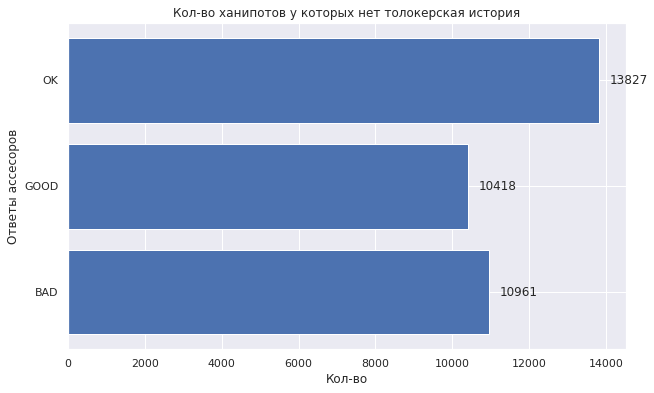

In [99]:
query_info(image_all[image_all['query'].isin(diff)], 'Кол-во ханипотов у которых нет толокерская история', 'assessors_answer')

В ханипотах с толокерской историей также нет перекосов в один из классов(GOOD-OK-BAD: 34%-32%-33%), 
в ханипотах без истории есть перекос в класс "ОК", но вроде некритичный (GOOD-OK-BAD: 39%-30%-31%)


#### еще сделаю мини-чек, распределение кол-ва размера истории у ханипотов

In [101]:
image_class.describe()

cnt
count  28954.000000
mean       8.363577
std       31.801441
min        1.000000
25%        3.000000
50%        4.000000
75%        7.000000
max     1044.000000

In [102]:
image_class['cnt'].sum()

242159

In [103]:
print('Ханипот с наибольшой историей', image_class['cnt'].max())
print('Ханипот с наименьшей историей', image_class['cnt'].min())
print('Квантиль, чтобы хистограмма адекватно отрисовалась', image_class['cnt'].quantile(0.95))
print('Ханипот с одной оценкой', image_class[image_class['cnt'] == 1].shape[0])

fig, ax = plt.subplots()
image_class[image_class['cnt'] < 100]['cnt'].hist(bins=100)
add_annotations("The number of toloker's answers for a given honeypot", "Number of honeypots", 'Распределение размера историй в ханипотах', False)

Ханипот с наибольшой историей 1044
Ханипот с наименьшей историей 1
Квантиль, чтобы хистограмма адекватно отрисовалась 13.0
Ханипот с одной оценкой 2867


Немного странные результаты, возможно стоит выкинуть ханипоты с историей равно 1 или больше 13, не могу пока сформулировать почему, просто это очень странно.

#### теперь смотрим насколько разметка "шумная" (насколько сходятся ответы толокеров и ассесоров)

In [117]:
image_class['accuracy_on_some_answer'] = image_class['some_answer'] == image_class['assessors_answer']
image_class['accuracy_on_aggr_answer'] = image_class['aggr_answer'] == image_class['assessors_answer']
image_class['accuracy_on_least_answer'] = image_class['least_common'] == image_class['assessors_answer']

In [68]:
print('Точность на наименее вероятных ответах толокеров', image_class['accuracy_on_least_answer'].mean())
print('Точность на случайных ответах толокеров', image_class['accuracy_on_some_answer'].mean())
print('Точность на агрегированных ответах толокеров', image_class['accuracy_on_aggr_answer'].mean())

Точность на наименее вероятных ответах толокеров 0.5373005456931684
Точность на случайных ответах толокеров 0.7779581404987221
Точность на агрегированных ответах толокеров 0.8549077847620363


Думаю хорошие результаты, с которыми можно работать.

In [121]:
image_class.groupby('assessors_answer')['accuracy_on_some_answer'].sum()

assessors_answer
BAD     7563
GOOD    7812
OK      7150
Name: accuracy_on_some_answer, dtype: int64

In [123]:
image_class.groupby('assessors_answer')['accuracy_on_aggr_answer'].sum()

assessors_answer
BAD     8189
GOOD    8630
OK      7934
Name: accuracy_on_aggr_answer, dtype: int64

### Анализ отдельных ответов толокеров 

In [109]:
res = {'BAD': 0, 'GOOD': 0, 'OK': 0}

for row in image_class.iterrows():
    for answer in row[1]['list_answers'].split(', '):
        res[answer] += 1
res

{'BAD': 73495, 'GOOD': 80669, 'OK': 87995}

In [115]:
image_class.groupby('assessors_answer')['cnt'].sum()

assessors_answer
BAD     75697
GOOD    85538
OK      80924
Name: cnt, dtype: int64

## 1.1 Текстовая разметка

#### вначале смотрим все ханипоты по картиночной разметке

In [69]:
# в хранилище есть дубликаты
text_all.drop_duplicates(inplace=True)
text_all['key'] = text_all['query'] + text_all['related_query']

Кол-во ханипотов в базе 3363
Кол-во строк в таблице 3363
Распределение ответов в ханипотах
                     query  related_query       key
assessors_answer                                   
DUPS              0.229854       0.229854  0.229854
GEN               0.047874       0.047874  0.047874
REF               0.537615       0.537615  0.537615
REL               0.140648       0.140648  0.140648
UNREL             0.044008       0.044008  0.044008


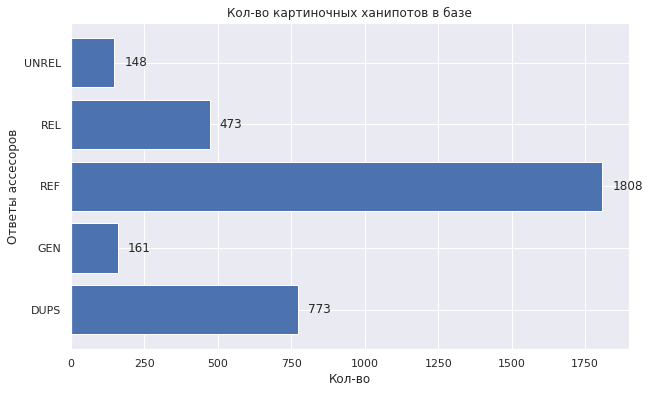

In [70]:
# unrel - несвязанные запросы
# gen - второй запрос является обобщением второго 
# ref - один запрос уточняет другой
# rel - запросы связаны
# dups - запросы дубли

sns.set(rc={'figure.figsize':(10,6)})
def query_info(df, title, column):
    print('Кол-во ханипотов в базе', len((df['key']).unique()))
    print('Кол-во строк в таблице', len(df['query']))
    print('Распределение ответов в ханипотах')
    hbars = df.groupby(column).count().reset_index()
    print(df.groupby(column).count()/df.groupby(column).count().sum())
    fig, ax = plt.subplots()
    ax.barh(hbars['assessors_answer'], hbars['query'])
    add_annotations('Кол-во', 'Ответы ассесоров', title, False)
    ax.bar_label(ax.containers[0], padding=10)

query_info(text_all, 'Кол-во картиночных ханипотов в базе', 'assessors_answer')

Распределение ханипотов по лейблам плохое (REL-REF-GEN-DUPS-UNREL: 53%-5%-5%-23%-4%)

#### теперь смотрим подтянувшиеся оценки толокеров

In [71]:
text_class['key'] = text_class['query'] + text_class['related_query']

In [72]:
print('Кол-во подтянувшихся уникальных ханипотов', len(text_class['key'].unique()))

Кол-во подтянувшихся уникальных ханипотов 3363


In [73]:
diff = np.setdiff1d(text_all['query'].unique(), text_class['query'].unique(), assume_unique=True)

In [74]:
# а тут наоборот подтянулись все оценки, но это разные проекты, с картинками один из основных наших проектов у которого огромная история, а текстовая разметка вспомогательная.
diff

array([], dtype=object)

In [75]:
print('Кол-во ханипотов без оценки:', len(diff))

Кол-во ханипотов без оценки: 0


In [76]:
query_info(text_class, 'Кол-во ханипотов у которых есть толокерская история', 'assessors_answer')

Кол-во ханипотов в базе 3363
Кол-во строк в таблице 3363
Распределение ответов в ханипотах
                  aggr_answer       cnt  least_common     query  \
assessors_answer                                                  
DUPS                 0.229854  0.229854      0.229854  0.229854   
GEN                  0.047874  0.047874      0.047874  0.047874   
REF                  0.537615  0.537615      0.537615  0.537615   
REL                  0.140648  0.140648      0.140648  0.140648   
UNREL                0.044008  0.044008      0.044008  0.044008   

                  related_query  some_answer       key  
assessors_answer                                        
DUPS                   0.229854     0.229854  0.229854  
GEN                    0.047874     0.047874  0.047874  
REF                    0.537615     0.537615  0.537615  
REL                    0.140648     0.140648  0.140648  
UNREL                  0.044008     0.044008  0.044008  


Так как все ханипоты подтянулись, то имеем аналогичное распределение. (REF-REL-GEN-DUPS-UNREL: 53%-5%-5%-23%-4%)


In [77]:
text_class.groupby('assessors_answer')['cnt'].sum().reset_index()

assessors_answer     cnt
0             DUPS  196802
1              GEN  153326
2              REF  192536
3              REL  133857
4            UNREL  163524

[Text(10, 0, '0.234276'),
 Text(10, 0, '0.182521'),
 Text(10, 0, '0.229197'),
 Text(10, 0, '0.159345'),
 Text(10, 0, '0.194661')]

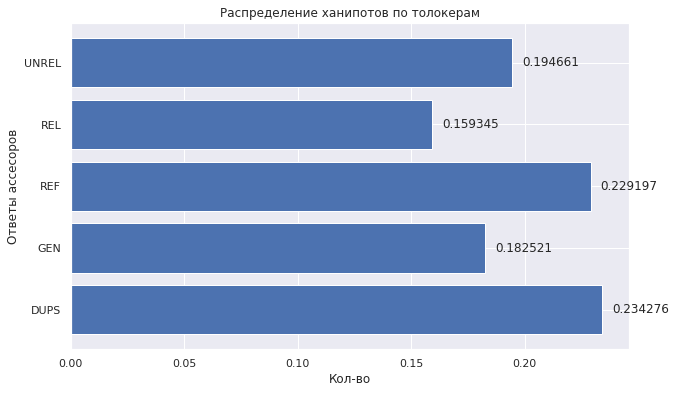

In [78]:
hbars = (text_class.groupby('assessors_answer')['cnt'].sum()/text_class.groupby('assessors_answer')['cnt'].sum().sum()).reset_index()
fig, ax = plt.subplots()
ax.barh(hbars['assessors_answer'], hbars['cnt'])
add_annotations('Кол-во', 'Ответы ассесоров', 'Распределение ханипотов по толокерам', False)
ax.bar_label(ax.containers[0], padding=10)

Распределение ответов ассесоров меня чуть больше успокаивает, ответы толокеров должны быть распределены примерно по 20%.

#### еще сделаю мини-чек, распределение кол-ва размера истории у ханипотов

Ханипот с наибольшой историей 21552
Ханипот с наименьшей историей 5
Квантиль, чтобы хистограмма адекватно отрисовалась 115.0
Ханипот с одной оценкой 0


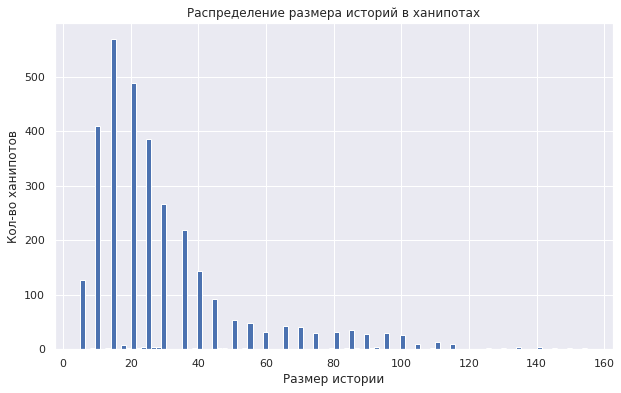

In [79]:
print('Ханипот с наибольшой историей', text_class['cnt'].max())
print('Ханипот с наименьшей историей', text_class['cnt'].min())
print('Квантиль, чтобы хистограмма адекватно отрисовалась', text_class['cnt'].quantile(0.95))
print('Ханипот с одной оценкой', text_class[text_class['cnt'] == 1].shape[0])

fig, ax = plt.subplots()
text_class[text_class['cnt'] < 160]['cnt'].hist(bins=100)
add_annotations('Размер истории', 'Кол-во ханипотов', 'Распределение размера историй в ханипотах', False)

Тут ханипотов не так много, поэтому история больше.

#### теперь смотрим насколько разметка "шумная" (насколько сходятся ответы толокеров и ассесоров)

In [82]:
text_class['accuracy_on_some_answer'] = text_class['some_answer'] == text_class['assessors_answer']
text_class['accuracy_on_aggr_answer'] = text_class['aggr_answer'] == text_class['assessors_answer']
text_class['accuracy_on_least_answer'] = text_class['least_common'] == text_class['assessors_answer']

In [83]:
print('Точность на наименее вероятных ответах толокеров', text_class['accuracy_on_least_answer'].mean())
print('Точность на случайных ответах толокеров', text_class['accuracy_on_some_answer'].mean())
print('Точность на случайных ответах толокеров', text_class['accuracy_on_aggr_answer'].mean())

Точность на наименее вероятных ответах толокеров 0.1977401129943503
Точность на случайных ответах толокеров 0.7853107344632768
Точность на случайных ответах толокеров 0.9066309842402617


Подозрительно высокая точность

## 1.3 Текстовая разметка_v2

#### вначале смотрим все ханипоты по текстовой разметке

In [211]:
text_all_2 = text_all_2.drop_duplicates(subset='query')

Кол-во ханипотов в базе 21387
Кол-во строк в таблице 21387
Распределение ответов в ханипотах
                     query
assessors_answer          
COMMERCIAL        0.193014
NOT_COMMERCIAL    0.806986


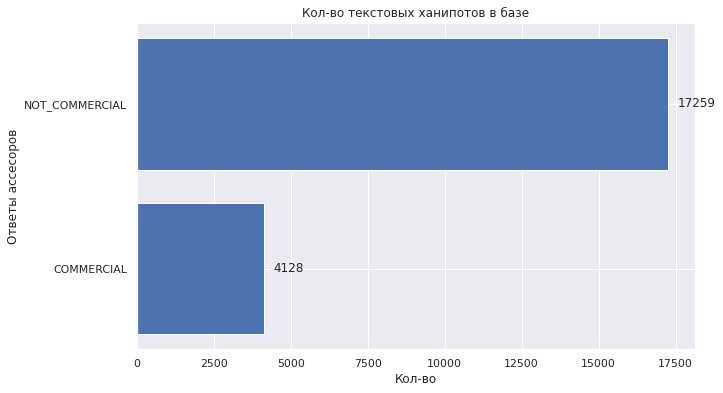

In [212]:
sns.set(rc={'figure.figsize':(10,6)})
def query_info(df, title, column):
    print('Кол-во ханипотов в базе', len(df['query'].unique()))
    print('Кол-во строк в таблице', len(df['query']))
    print('Распределение ответов в ханипотах')
    hbars = df.groupby(column).count().reset_index()
    print(df.groupby(column).count()/df.groupby(column).count().sum())
    fig, ax = plt.subplots()
    ax.barh(hbars['assessors_answer'], hbars['query'])
    add_annotations('Кол-во', 'Ответы ассесоров', title, False)
    ax.bar_label(ax.containers[0], padding=10)

query_info(text_all_2, 'Кол-во текстовых ханипотов в базе', 'assessors_answer')

Распределение ханипотов по лейблам примерно одинаковое (GOOD-OK-BAD: 37%-31%-32%). Чекнул что все ханипоты уникальны.

#### теперь смотрим подтянувшиеся оценки толокеров

In [190]:
text_all_2.shape

(21387, 2)

In [191]:
print('Кол-во подтянувшихся уникальных ханипотов', len(text_class_2['query'].unique()))

Кол-во подтянувшихся уникальных ханипотов 21387


In [192]:
sns.set(rc={'figure.figsize':(10,6)})
def query_info(df, title, column):
    print('Кол-во ханипотов в базе', len(df['query'].unique()))
    print('Кол-во строк в таблице', len(df['query']))
    print('Распределение ответов в ханипотах')
    hbars = df.groupby(column).count().reset_index()
    print(df.groupby(column).count()/df.groupby(column).count().sum())
    fig, ax = plt.subplots()
    ax.barh(hbars['assessors_answer'], hbars['query'])
    add_annotations('The number of honeypots', 'Honeypots labels', title, False)
    ax.bar_label(ax.containers[0], padding=10)

In [193]:
query_info(text_class_2, 'Кол-во ханипотов у которых есть толокерская история', 'assessors_answer')

Кол-во ханипотов в базе 21387
Кол-во строк в таблице 21402
Распределение ответов в ханипотах
                  aggr_answer       cnt  least_common  list_answers     query  \
assessors_answer                                                                
COMMERCIAL           0.193206  0.193206      0.193206      0.193206  0.193206   
NOT_COMMERCIAL       0.806794  0.806794      0.806794      0.806794  0.806794   

                  some_answer  
assessors_answer               
COMMERCIAL           0.193206  
NOT_COMMERCIAL       0.806794  


В ханипотах с толокерской историей также нет перекосов в один из классов(GOOD-OK-BAD: 34%-32%-33%), 
в ханипотах без истории есть перекос в класс "ОК", но вроде некритичный (GOOD-OK-BAD: 39%-30%-31%)


#### еще сделаю мини-чек, распределение кол-ва размера истории у ханипотов

In [194]:
text_class_2.describe()

cnt
count  21402.000000
mean      67.579105
std      818.277846
min        5.000000
25%       10.000000
50%       15.000000
75%       25.000000
max    35798.000000

In [195]:
text_class_2['cnt'].sum()

1446328

In [196]:
print('Ханипот с наибольшой историей', text_class_2['cnt'].max())
print('Ханипот с наименьшей историей', text_class_2['cnt'].min())
print('Квантиль, чтобы хистограмма адекватно отрисовалась', text_class_2['cnt'].quantile(0.95))
print('Ханипот с одной оценкой', text_class_2[text_class_2['cnt'] == 1].shape[0])

fig, ax = plt.subplots()
text_class_2[text_class_2['cnt'] < 100]['cnt'].hist(bins=100)
add_annotations("The number of toloker's answers for a given honeypot", "Number of honeypots", 'Распределение размера историй в ханипотах', False)

Ханипот с наибольшой историей 35798
Ханипот с наименьшей историей 5
Квантиль, чтобы хистограмма адекватно отрисовалась 222.0
Ханипот с одной оценкой 0


Немного странные результаты, возможно стоит выкинуть ханипоты с историей равно 1 или больше 13, не могу пока сформулировать почему, просто это очень странно.

#### теперь смотрим насколько разметка "шумная" (насколько сходятся ответы толокеров и ассесоров)

In [197]:
text_class_2['accuracy_on_some_answer'] = text_class_2['some_answer'] == text_class_2['assessors_answer']
text_class_2['accuracy_on_aggr_answer'] = text_class_2['aggr_answer'] == text_class_2['assessors_answer']
text_class_2['accuracy_on_least_answer'] = text_class_2['least_common'] == text_class_2['assessors_answer']

In [208]:
print('Точность на наименее вероятных ответах толокеров', text_class_2['accuracy_on_least_answer'].mean())
print('Точность на случайных ответах толокеров', text_class_2['accuracy_on_some_answer'].mean())
print('Точность на агрегированных ответах толокеров', text_class_2['accuracy_on_aggr_answer'].mean())

Точность на наименее вероятных ответах толокеров 0.4762639005700402
Точность на случайных ответах толокеров 0.8234277170357911
Точность на агрегированных ответах толокеров 0.8736566676011588


In [ ]:
text_class_2

Думаю хорошие результаты, с которыми можно работать.

In [210]:
text_class_2.groupby('assessors_answer')['accuracy_on_some_answer'].count()

assessors_answer
COMMERCIAL         4135
NOT_COMMERCIAL    17267
Name: accuracy_on_some_answer, dtype: int64

In [199]:
text_class_2.groupby('assessors_answer')['accuracy_on_some_answer'].sum()

assessors_answer
COMMERCIAL         3434
NOT_COMMERCIAL    14189
Name: accuracy_on_some_answer, dtype: int64

In [200]:
text_class_2.groupby('assessors_answer')['accuracy_on_aggr_answer'].sum()

assessors_answer
COMMERCIAL         3809
NOT_COMMERCIAL    14889
Name: accuracy_on_aggr_answer, dtype: int64

### Анализ отдельных ответов толокеров 

In [203]:
text_class_2['list_answers'] = text_class_2['list_answers'].str.decode('utf8')

In [206]:
res = {'COMMERCIAL': 0, 'NOT_COMMERCIAL': 0}

for row in text_class_2.iterrows():
    for answer in row[1]['list_answers'].split(', '):
        res[answer] += 1
res

{'COMMERCIAL': 745145, 'NOT_COMMERCIAL': 701183}

In [207]:
text_class_2.groupby('assessors_answer')['cnt'].sum()

assessors_answer
COMMERCIAL        758714
NOT_COMMERCIAL    687614
Name: cnt, dtype: int64

In [181]:
text_class_2[text_class_2['assessors_answer'] == 'COMMERCIAL'].sample(20)

aggr_answer assessors_answer   cnt    least_common  \
1547  COMMERCIAL       COMMERCIAL    10      COMMERCIAL   
1838  COMMERCIAL       COMMERCIAL     5  NOT_COMMERCIAL   
3810  COMMERCIAL       COMMERCIAL   292  NOT_COMMERCIAL   
2130  COMMERCIAL       COMMERCIAL    15  NOT_COMMERCIAL   
1789  COMMERCIAL       COMMERCIAL    15  NOT_COMMERCIAL   
449   COMMERCIAL       COMMERCIAL   281  NOT_COMMERCIAL   
2210  COMMERCIAL       COMMERCIAL     5      COMMERCIAL   
3159  COMMERCIAL       COMMERCIAL    45  NOT_COMMERCIAL   
3646  COMMERCIAL       COMMERCIAL    63  NOT_COMMERCIAL   
2590  COMMERCIAL       COMMERCIAL     5      COMMERCIAL   
3316  COMMERCIAL       COMMERCIAL    30  NOT_COMMERCIAL   
557   COMMERCIAL       COMMERCIAL    60  NOT_COMMERCIAL   
3512  COMMERCIAL       COMMERCIAL    60  NOT_COMMERCIAL   
965   COMMERCIAL       COMMERCIAL  1118  NOT_COMMERCIAL   
1867  COMMERCIAL       COMMERCIAL    10  NOT_COMMERCIAL   
1993  COMMERCIAL       COMMERCIAL   181  NOT_COMMERCIAL   
276   COMMERCIAL       COMMERCIAL    10  NOT_COMMERCIAL   
2277  COMMERCIAL       COMMERCIAL   210  NOT_COMMERCIAL   
2496  COMMERCIAL       COMMERCIAL    30  NOT_COMMERCIAL   
2217  COMMERCIAL       COMMERCIAL    10  NOT_COMMERCIAL   

                                                  query     some_answer  \
1547                          Меховой палантин из норки      COMMERCIAL   
1838                          Референсная видеокарта r9      COMMERCIAL   
3810                                   тактические часы      COMMERCIAL   
2130                        Фото белого платья с маками      COMMERCIAL   
1789                                            Попскет      COMMERCIAL   
449                             france football uniform  NOT_COMMERCIAL   
2210  Чехол Moshi SENSECOVER для Apple iphone x/XS L...      COMMERCIAL   
3159          модели платья из легкого шелка для отдыха      COMMERCIAL   
3646                                   сандалии детские      COMMERCIAL   
2590                           детский комплекс уличный      COMMERCIAL   
3316                          органайзер для канцелярии      COMMERCIAL   
557                                        iphone x max      COMMERCIAL   
3512                          пустышка теомометрр маман      COMMERCIAL   
965                                             xl-747h      COMMERCIAL   
1867                               Самсунг а8 2018 года      COMMERCIAL   
1993            Стиральная машина Indesit IWSB 5085 CIS      COMMERCIAL   
276                            Xiaomi Redmi Note 7 фото  NOT_COMMERCIAL   
2277                                 авелин трусы 44079  NOT_COMMERCIAL   
2496       вязаный конверт для новорожденного на молнии      COMMERCIAL   
2217                 Шапки ушанки мужские зимние адидас      COMMERCIAL   

      accuracy_on_some_answer  accuracy_on_aggr_answer  \
1547                     True                     True   
1838                     True                     True   
3810                     True                     True   
2130                     True                     True   
1789                     True                     True   
449                     False                     True   
2210                     True                     True   
3159                     True                     True   
3646                     True                     True   
2590                     True                     True   
3316                     True                     True   
557                      True                     True   
3512                     True                     True   
965                      True                     True   
1867                     True                     True   
1993                     True                     True   
276                     False                     True   
2277                    False                     True   
2496                     True                     True   
2217                     True